### julia_set.pdf

Adapted from `demos/learning/geometric_changes.ipynb`.

In [1]:
%matplotlib inline

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nengo
import nengo_spa as spa
from ssp.maps import Spatial2D

In [3]:
try:
    from numba import njit  # optional

except ImportError:
    print("`pip install numba` to significantly speed this up!")
    njit = lambda x: x  # this decorator does nothing

    
@njit
def julia_recurse(z, c, n_iter=1000, R=10):
    if abs(z) > R or n_iter <= 0:
        return 0
    return 1 + julia_recurse(z**2 + c, c, n_iter - 1)
    
    
@njit
def julia_set(c, n_iter=1000, R=10,
              resolution=(500, 500),
              x=(-1.5, 1.5), y=(-1.5, 1.5)):
    """Adapted from https://scipython.com/book/chapter-7-matplotlib/problems/p72/the-julia-set/"""
    im_width, im_height = resolution
    xmin, xmax = x
    xwidth = xmax - xmin
    ymin, ymax = y
    yheight = ymax - ymin

    julia = np.zeros((im_height, im_width))
    for ix in range(im_width):
        for iy in range(im_height):
            nit = 0
            # Map pixel position to a point in the complex plane
            z = complex(ix / im_width * xwidth + xmin,
                        iy / im_height * yheight + ymin)
            # Do the iterations
            ratio = julia_recurse(z, c, n_iter, R) / n_iter
            julia[im_height-1-iy, ix] = ratio

    return julia

In [15]:
zoom = 0.5  # 1.45
res = 501
# c = complex(-0.4, 0.6)
c = complex(-0.1, 0.65)

R = np.roots([1, -1, -np.abs(c)])[0]
R

1.4527052649682877

In [5]:
dim = 1024
scale = zoom  # 0.5 * res * np.sqrt(2)  # 0.5 because the grid is [-1, 1]^2, sqrt(2) because diameter of SSP

print("Pixels:", res**2)
print("Dimensionality:", dim)
print("Scale:", scale)

Pixels: 251001
Dimensionality: 1024
Scale: 0.5


In [6]:
class JuliaSpatial2D(Spatial2D):

    def encode_point(self, x, y, name=None):
        tag = self.voc["Identity"] if name is None else self.voc[name]

        magic1 = 50
        magic2 = 0
        magic3 = 4
        
        x *= self.scale
        y *= self.scale
        i = julia_recurse(x + 1j * y, c) / magic1 + magic2

        return (
            tag
            * (self.X ** i) ** (magic3 * x)
            * (self.Y ** i) ** (magic3 * y)
        )

In [7]:
ssp_map = JuliaSpatial2D(
    dim=dim, scale=scale,
    rng=np.random.RandomState(seed=0))
ssp_map.build_grid(x_len=1, y_len=1, x_spaces=res, y_spaces=res, centered=True)

# Compute the heatmap for the columns of the identity matrix
# Based on https://github.com/ctn-waterloo/metric-representation/blob/b822b49ade9aca81f564182bedb5e35a78761367/metric_representation/regions/region_utils.py#L9
# which in turn is adapted from Terry's code for solving from region vectors from way back
I = np.eye(dim)
A = np.asarray(
    [ssp_map.compute_heatmap(ssp=spa.SemanticPointer(I[i])).flatten()
     for i in range(dim)]
)

In [29]:
solver = nengo.solvers.LstsqL2(reg=1e-2)

heatmap = julia_set(
    c=c,
    R=R,
    resolution=(res, res),
    x=(-zoom, zoom),
    y=(-zoom, zoom),
)

solution, info = solver(A.T, heatmap.reshape(-1, 1))
ssp = spa.SemanticPointer(solution.squeeze(axis=1))
sims = ssp_map.compute_heatmap(ssp)

In [30]:
from nengo.utils.numpy import rms, rmse
assert np.allclose(A.T.dot(solution).reshape(heatmap.shape), sims)
assert np.allclose(rmse(A.T.dot(solution), heatmap.reshape(-1, 1)), info['rmses'])
info['rmses'] / rms(heatmap)

array([0.37791616])

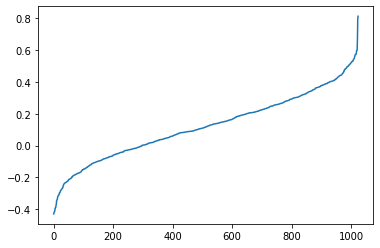

In [10]:
plt.figure()
plt.plot(sorted(solution))
plt.show()

In [11]:
# https://stackoverflow.com/a/45098466/1030876
from matplotlib.colors import ListedColormap
palette = sns.color_palette("RdBu_r", 512)
cmap = ListedColormap(palette)


def make_plot(sims, ax, cmap=cmap, vmin=0, vmax=1):
    ax.imshow(sims, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('equal')
    sns.despine(left=True, bottom=True, ax=ax)

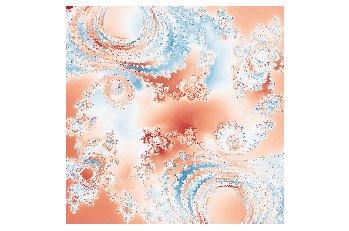

In [12]:
make_plot(ssp_map.compute_heatmap(spa.SemanticPointer(next(ssp_map.voc.pointer_gen))), ax=plt.gca(), vmin=None, vmax=None)

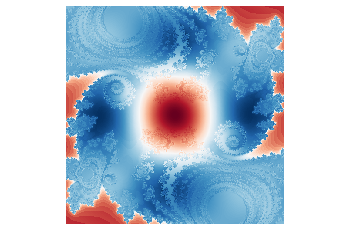

In [13]:
make_plot(ssp_map.compute_heatmap(ssp_map.voc["Identity"]), ax=plt.gca(), vmin=None, vmax=None)

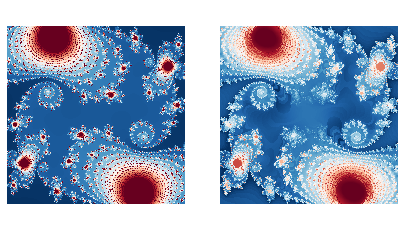

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

make_plot(heatmap, ax=axes[0]) #, vmax=None)
make_plot(sims, ax=axes[1]) #, vmax=None)

fig.savefig("../figures/rSSP-julia-set.pdf", bbox_inches='tight')

fig.show()